# Handwritten digit classification using Convolutional Neural Networks

Welcome! In this lab, you'll learn how to perform image classification using convolutional neural networks. In particular, we will train and evaluate a simple feed-forward Convolutional Neural Network on the MNIST dataset for the task of handwritten digit classification. We will go through all the steps, including loading the data, building and training a model, making predictions and calculating the classification accuracy. We will use the [Tensorflow library](https://github.com/tensorflow/tensorflow) to build and train our model.

This tutorial is based on Tensorflow's official tutorial [Deep MNIST for Experts](https://www.tensorflow.org/versions/r1.0/get_started/mnist/pros) and the jupyter notebook [TensorFlow Tutorial](https://github.com/ianlewis/tensorflow-examples/blob/master/notebooks/Tensorflow%20MNIST%20Tutorial%202.ipynb)

# Load MNIST data

The MNIST dataset provides 60000 images of handwritten digits for training and 10000 images for testing. Each image has a size of 28x28 pixels. Each image in the dataset has an associated label, which corresponds to the digit depicted in the image. So each label has a value from 0 to 9. 
![MNIST images](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

In [1]:
# Import tensorflow
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../data/MNIST_data/", one_hot=True, source_url='http://yann.lecun.com/exdb/mnist/')

/cis/home/efi/work/ar_libs/anaconda3/envs/action_detection_tf1.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting ../data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/t10k-labels-idx1-ubyte.gz


# Visualize data

We will now display one of the training images of the MNIST dataset. We will also read its associated label. Note that the image is provided in its flattened version, i.e. as a vector of 784 (28*28) elements, so we have to reshape it before displaying it. Also, note that the label is provided in an one-hot encoded format, i.e. if the digit is 2, the label is the following vector: $[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]$

One-hot encoded training label: 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0
Integer training label: 8
Flattened training image shape: (784,)


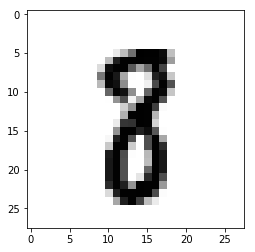

In [2]:
# Load a training sample
training_sample_ind = 50
training_sample_image = mnist.train.images[training_sample_ind, :]
training_sample_label = mnist.train.labels[training_sample_ind, :]

# Inspect image and label shapes
print('One-hot encoded training label: {}'.format(', '.join(map(str, training_sample_label))))
print('Integer training label: {}'.format(np.argmax(training_sample_label)))
print('Flattened training image shape: {}'.format(str(training_sample_image.shape)))

# Display image
training_sample_image_reshaped = np.reshape(training_sample_image, [28, 28])
plt.imshow(training_sample_image_reshaped, cmap=plt.get_cmap('gray_r'))
plt.show()


# Define placeholders for input image and ground truth label

Placeholders are nodes in the dataflow graph that we will be feeding with data during execution.

In [3]:
x = tf.placeholder(tf.float32, [None, 784])  # batch of images: (batch_size, 28*28)
y_ = tf.placeholder(tf.float32, [None, 10])  # batch of image labels: (batch_size, 10), one-hot encoded.

# Convolutional Networks

## Convolution & Pooling

![](http://deeplearning.stanford.edu/wiki/images/6/6c/Convolution_schematic.gif)

http://deeplearning.stanford.edu/wiki/index.php/Feature_extraction_using_convolution

Our pooling is plain old max pooling over 2x2 blocks. To keep our code cleaner, let's also abstract those operations into functions.

![](http://www.wildml.com/wp-content/uploads/2015/11/Screen-Shot-2015-11-05-at-2.18.38-PM.png)

## Define functions for 2D convolution and max pooling
TensorFlow gives us a lot of flexibility in convolution and pooling operations. How do we handle the boundaries? What is our stride size? In this example, we choose the vanilla version. Our convolutions use a stride of one and are zero padded so that the output is the same size as the input.

In [4]:
def conv2d(x, W):
    # x: [batch_size, in_height, in_width, in_channels]
    # W: [filter_height, filter_width, in_channels, out_channels]
    # strides: 1-D tensor of length 4. The stride of the sliding window for each dimension of input.
    # padding: 'SAME' (zero pad input to ensure output has the same height/width)
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    # x: [batch_size, in_height, in_width, in_channels]
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

## Define functions for Weight & Biases Initialization

To create our multilayer convolutional network, we're going to need to create a lot of weights and biases. One should generally initialize weights with a small amount of noise for symmetry breaking, and to prevent 0 gradients. Instead of doing this repeatedly while we build the model, let's create two handy functions to do it for us.

In [5]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Build a Multilayer Convolutional Network
![CNN](https://cdn-images-1.medium.com/max/1600/1*irWQaiIjHS27ZAPaVDoj6w.png)

## First Convolutional Layer

We can now implement our first layer. It will consist of convolution, followed by the activation function (ReLU), followed by max pooling. The convolution will compute 32 features for each 5x5 patch. Its weight tensor will have a shape of [5, 5, 1, 32]. The first two dimensions are the patch size, the next is the number of input channels, and the last is the number of output channels. We will also have a bias vector with a component for each output channel.

In [6]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

To apply the layer, we first reshape x to a 4d tensor, with the second and third dimensions corresponding to image width and height, and the final dimension corresponding to the number of color channels.

In [7]:
# Reshape input of [batch_size, 784] to [batch_size, 28, 28, 1]
x_image = tf.reshape(x, [-1,28,28,1])

We then convolve x_image with the weight tensor, add the bias, apply the ReLU function, and finally max pool.

In [8]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

## Second Convolutional Layer

In order to build a deep network, we stack several layers of this type. The second layer will have 64 features for each 5x5 patch. Note that now the number of input channels is 32 (as many as the output channels of the previous layer).

In [9]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

## Fully Connected Layer

Now that the image size has been reduced to 7x7, we add a fully-connected layer with 1024 neurons to allow processing on the entire image. We reshape the tensor from the pooling layer into a batch of vectors, multiply by a weight matrix, add a bias, and apply a ReLU.

In [10]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

## Dropout

To reduce overfitting, we will apply dropout before the readout layer. We create a placeholder for the probability that a neuron's output is kept during dropout. This allows us to turn dropout on during training, and turn it off during testing.
<img src="https://cdn-images-1.medium.com/max/1044/1*iWQzxhVlvadk6VAJjsgXgg.png" alt="dropout" width="500px"/>

In [11]:
keep_prob = tf.placeholder(tf.float32)
# With probability keep_prob, outputs the input element scaled up by 1 / keep_prob,
# otherwise outputs 0. The scaling is so that the expected sum is unchanged.
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

## Classification Layer

Finally, we add another fully connected layer to get action scores (logits) and then apply softmax to get a probability for each digit.

In [12]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

# Define Loss, Optimizer and Evaluation Metric operations

In [13]:
# Loss function (cross entropy)
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))

# Training operation
learning_rate = 1e-4
optimizer_name = 'Adam'

if optimizer_name == 'sgd':
    optimizer = tf.train.MomentumOptimizer(
        learning_rate=learning_rate)
elif optimizer_name == 'rmsprop':
    optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
elif optimizer_name == 'Adagrad':
    optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
elif optimizer_name == 'Adadelta':
    optimizer = tf.train.AdadeltaOptimizer(learning_rate=learning_rate)
elif optimizer_name == 'Adam':
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
else:
    raise ValueError("Not supported optimizer: %s", optimizer_name)

train_step = optimizer.minimize(cross_entropy)


# Evaluation metric
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Train and Evaluate the Model

How well does this model do?



In [14]:
# initialize variables and session

init = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()

sess = tf.Session()
sess.run(init)
sess.run(init_l)

# Run mini-batch training on 50 elements 20000 times.
nb_iterations = 20000
batch_size = 50
dropout_rate = 0.5


for i in range(nb_iterations):
    batch = mnist.train.next_batch(batch_size)
    if i%100 == 0:
        train_accuracy = sess.run(accuracy, feed_dict={
             x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g" % (i, train_accuracy)) 

    sess.run(train_step, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g" % sess.run(accuracy, feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0.06
step 100, training accuracy 0.8
step 200, training accuracy 0.88
step 300, training accuracy 0.92
step 400, training accuracy 0.96
step 500, training accuracy 0.94
step 600, training accuracy 0.96
step 700, training accuracy 0.94
step 800, training accuracy 0.86
step 900, training accuracy 0.96
step 1000, training accuracy 0.98
step 1100, training accuracy 0.98
step 1200, training accuracy 0.94
step 1300, training accuracy 0.92
step 1400, training accuracy 0.98
step 1500, training accuracy 1
step 1600, training accuracy 0.92
step 1700, training accuracy 0.94
step 1800, training accuracy 1
step 1900, training accuracy 0.96
step 2000, training accuracy 1
step 2100, training accuracy 1
step 2200, training accuracy 0.96
step 2300, training accuracy 1
step 2400, training accuracy 0.98
step 2500, training accuracy 0.98
step 2600, training accuracy 1
step 2700, training accuracy 0.98
step 2800, training accuracy 0.98
step 2900, training accuracy 0.98
step 3000, 

The final test set accuracy after running this code should be approximately 99.2%.

We have learned how to quickly and easily build, train, and evaluate a fairly sophisticated deep learning model using TensorFlow.